In [1]:
import csv
import gc
from pathlib import Path
import numpy as np
import pandas as pd
from pyprojroot.here import here
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import cupy as cp
from cuml.cluster import KMeans as cuKMeans
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF


In [2]:
gct_path = here('output/gtex/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz')

gtex_tpm = pd.read_csv(
    gct_path,
    sep='\t',
    compression='gzip',
    header=2,
    low_memory=False
)

print(gtex_tpm.shape)

gtex_tpm.head()

(56200, 17384)


,Name,Description,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,...,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
0,ENSG00000223972.5,DDX11L1,0.00000,0.000,0.000,0.00000,0.000,0.000,0.00,0.00000,...,0.00000,0.03629,0.00000,0.00,0.00000,0.0000,0.000,0.00000,0.01965,0.02522
1,ENSG00000227232.5,WASH7P,8.76400,3.861,7.349,11.07000,3.306,5.389,11.99,16.95000,...,1.60600,2.26800,5.38600,2.31,2.45600,4.0230,1.922,2.85700,0.86960,2.16700
2,ENSG00000278267.1,MIR6859-1,0.00000,0.000,1.004,0.00000,0.000,0.000,0.00,0.00000,...,0.00000,0.00000,0.00000,0.00,0.00000,0.0000,0.000,0.00000,0.00000,0.00000
3,ENSG00000243485.5,MIR1302-2HG,0.07187,0.000,0.000,0.06761,0.000,0.000,0.00,0.00000,...,0.00000,0.00000,0.06073,0.00,0.08464,0.1435,0.000,0.05216,0.00000,0.00000
4,ENSG00000237613.2,FAM138A,0.00000,0.000,0.000,0.00000,0.000,0.000,0.00,0.03904,...,0.02429,0.00000,0.00000,0.00,0.00000,0.0000,0.000,0.00000,0.00000,0.00000


In [3]:
# aggregate by Description
aggregated_gtex = gtex_tpm.groupby('Description', as_index=False).sum(numeric_only=True)

# samples are all columns except Description
samples = [c for c in aggregated_gtex.columns if c != 'Description']

# create a pandas DataFrame (genes as index, samples as columns) with float dtype
gtex_data = aggregated_gtex.set_index('Description')[samples].astype(float)

# set index name to 'Gene'
gtex_data.index.name = 'Gene'

genes = gtex_data.index.tolist()

print("aggregated_gtex.shape:", aggregated_gtex.shape)
print("data_mat.shape:", gtex_data.shape)
print("n_genes:", len(genes), "n_samples:", len(samples))

gtex_data.head()

aggregated_gtex.shape: (54592, 17383)
data_mat.shape: (54592, 17382)
n_genes: 54592 n_samples: 17382


,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,...,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
Gene,,,,,,,,,,,,,,,,,,,,,
5S_rRNA,0.9801,0.000,0.5735,0.000,0.6586,0.4858,1.2600,0.0000,1.1293,0.0000,...,0.5126,0.247,0.8914,0.0000,1.7536,2.225,1.3008,0.3828,0.0000,0.000
5_8S_rRNA,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000
7SK,0.0000,0.000,0.2290,0.000,0.0000,0.0000,0.5369,0.3194,0.0000,0.1821,...,0.1185,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000
A1BG,5.4450,0.662,10.1500,11.180,5.5130,5.4450,13.8400,4.0000,5.2140,4.7880,...,4.9900,2.005,2.7410,1.1230,1.4640,2.599,0.8323,7.9890,1.3050,2.455
A1BG-AS1,1.6320,0.200,0.9190,5.934,1.3770,2.6640,7.7670,1.9900,2.8750,1.7300,...,1.8050,1.467,2.8700,0.8808,0.8052,2.025,0.7385,3.4250,0.1685,0.989


In [4]:
# Remove the object
del gtex_tpm

In [5]:
samples = gtex_data.columns
genes = gtex_data.index

X = gtex_data.values.T  

In [6]:
n_components = min(412, X.shape[1])
pca = PCA(n_components=n_components, svd_solver="randomized", random_state=0)

W = pca.fit_transform(X)     
H = pca.components_         

pc_names = [f"PC{i+1}" for i in range(W.shape[1])]

gtex_pca_scores = pd.DataFrame(W, index=samples, columns=pc_names)

gtex_pca_loadings = pd.DataFrame(H, index=pc_names, columns=genes)

gtex_pca_B = gtex_pca_scores.T 
gtex_pca_B.index.name = "PC"

In [7]:
if np.min(X) < 0:
    X_nonneg = X - np.min(X) + 1e-9
else:
    X_nonneg = X

n_components = min(412, X_nonneg.shape[0], X_nonneg.shape[1])

nmf = NMF(
    n_components=n_components,
    init="nndsvd",
    random_state=0,
    max_iter=1000,
    tol=1e-4
)

W = nmf.fit_transform(X_nonneg)
H = nmf.components_

comp_names = [f"LV{i+1}" for i in range(W.shape[1])]

gtex_nmf_scores = pd.DataFrame(W, index=samples, columns=comp_names)
gtex_nmf_loadings = pd.DataFrame(H, index=comp_names, columns=genes)
gtex_nmf_B = gtex_nmf_scores.T
gtex_nmf_B.index.name = "LV"


/home/msubirana/miniconda3/envs/gpu-kmeans/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


In [8]:
path = here('data/gtex/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt')

gtex_meta = pd.read_csv(
    path,
    sep='\t',
    header=0,
    dtype=str,
    quoting=csv.QUOTE_NONE,   
    engine='python',
    comment=None,            
    keep_default_na=False,
    on_bad_lines='warn'     
)

print(gtex_meta.shape)
gtex_meta.head()

(22951, 63)


,SAMPID,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
0,GTEX-1117F-0003-SM-58Q7G,,B1,,,Blood,Whole Blood,0013756,1188,,...,,,,,,,,,,
1,GTEX-1117F-0003-SM-5DWSB,,B1,,,Blood,Whole Blood,0013756,1188,,...,,,,,,,,,,
2,GTEX-1117F-0003-SM-6WBT7,,B1,,,Blood,Whole Blood,0013756,1188,,...,,,,,,,,,,
3,GTEX-1117F-0011-R10a-SM-AHZ7F,,"B1, A1",,,Brain,Brain - Frontal Cortex (BA9),0009834,1193,,...,,,,,,,,,,
4,GTEX-1117F-0011-R10b-SM-CYKQ8,,"B1, A1",,7.2,Brain,Brain - Frontal Cortex (BA9),0009834,1193,,...,,,,,,,,,,


In [9]:
display(gtex_meta['SMTS'].value_counts())
total_tissues = len(gtex_meta['SMTS'].value_counts())
total_tissues

SMTS
Blood              3480
Brain              3326
Skin               2014
Esophagus          1582
Blood Vessel       1473
Adipose Tissue     1327
Heart              1141
Muscle             1132
Lung                867
Colon               821
Thyroid             812
Nerve               722
Breast              480
Testis              406
Stomach             381
Pancreas            360
Pituitary           301
Adrenal Gland       275
Prostate            262
Spleen              260
Liver               251
Bone Marrow         217
Ovary               195
Small Intestine     193
Salivary Gland      181
Vagina              173
Uterus              166
Kidney              104
Bladder              21
Cervix Uteri         19
Fallopian Tube        9
Name: count, dtype: int64

31

Keep samples in expression and in metadata

In [10]:
meta = gtex_meta.copy()
if meta.index.name != "SAMPID":
    meta = meta.set_index("SAMPID")

sample_ids_expr = pd.Index(gtex_data.columns.astype(str).str.strip(), name="SAMPID")
sample_ids_meta = meta.index.astype(str).str.strip()
common_ids = sample_ids_expr.intersection(sample_ids_meta)

if len(common_ids) == 0:
    raise ValueError("No overlapping sample IDs between expression and metadata.")

gtex_data_common = gtex_data.loc[:, common_ids]    
meta_common = meta.loc[common_ids] 

In [11]:
y_true = meta.loc[common_ids, "SMTS"].astype(str).to_numpy()

Scale data

In [12]:
scaler = StandardScaler()

gtex_data_scaled = pd.DataFrame(
    scaler.fit_transform(gtex_data_common),
    index=gtex_data_common.index,
    columns=gtex_data_common.columns
)

gtex_data_t = gtex_data_scaled.T 

In [13]:
display(gtex_data_scaled.shape)
gtex_data_scaled.head()

(54592, 17382)

SAMPID,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,...,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
Gene,,,,,,,,,,,,,,,,,,,,,
5S_rRNA,-0.080177,-0.033530,-0.080502,-0.084744,-0.024235,-0.042702,-0.096357,-0.073461,-0.037272,-0.065809,...,-0.029165,-0.033556,-0.033426,-0.029671,-0.034518,-0.049112,-0.040022,-0.056493,-0.030626,-0.043514
5_8S_rRNA,-0.084709,-0.033530,-0.083103,-0.084744,-0.025139,-0.043866,-0.103474,-0.073461,-0.039721,-0.065809,...,-0.030005,-0.034015,-0.035136,-0.029671,-0.038172,-0.055903,-0.043081,-0.057699,-0.030626,-0.043514
7SK,-0.084709,-0.033530,-0.082065,-0.084744,-0.025139,-0.043866,-0.100441,-0.072180,-0.039721,-0.065155,...,-0.029811,-0.034015,-0.035136,-0.029671,-0.038172,-0.055903,-0.043081,-0.057699,-0.030626,-0.043514
A1BG,-0.059529,-0.032318,-0.037054,-0.033022,-0.017573,-0.030826,-0.025294,-0.057419,-0.028414,-0.048608,...,-0.021831,-0.030292,-0.029878,-0.027852,-0.035121,-0.047971,-0.041124,-0.032534,-0.028444,-0.037682
A1BG-AS1,-0.077162,-0.033164,-0.078934,-0.057292,-0.023249,-0.037486,-0.059600,-0.065480,-0.033486,-0.059594,...,-0.027048,-0.031291,-0.029631,-0.028244,-0.036494,-0.049723,-0.041344,-0.046910,-0.030345,-0.041164


# Basic GPU kmeans example

## RAPIDS approach

## GPU kmeans ensemble

In [14]:
int(np.sqrt(gtex_data_scaled.shape[1]))

131

In [15]:
INITIAL_RANDOM_STATE = 10000
K_MIN = 20
K_MAX = 40
K_STEP = 5
N_REPS_PER_K = 50
KMEANS_N_INIT = 10

print("INITIAL_RANDOM_STATE:", INITIAL_RANDOM_STATE)
print("K_MIN:", K_MIN)
print("K_MAX:", K_MAX)
print("K_STEP:", K_STEP)
print("N_REPS_PER_K:", N_REPS_PER_K)
print("KMEANS_N_INIT:", KMEANS_N_INIT)
print("total_tissues:", total_tissues)

INITIAL_RANDOM_STATE: 10000
K_MIN: 20
K_MAX: 40
K_STEP: 5
N_REPS_PER_K: 50
KMEANS_N_INIT: 10
total_tissues: 31


In [16]:
import cupy as cp
from cuml.cluster import KMeans as cuKMeans

# X: (n_samples, n_features). Move to GPU; float32 saves memory.
X_gpu = cp.asarray(gtex_data_t.astype("float32"))

records = []
best = {"ari": -np.inf, "k": None, "seed": None, "labels": None}

k_values = list(range(K_MIN, K_MAX + 1, K_STEP))
if total_tissues not in k_values:
    k_values.append(total_tissues)
    k_values = sorted(set(k_values)) 

for k in k_values:
    for rep in range(N_REPS_PER_K):
        km = cuKMeans(
            n_clusters=k,
            init="k-means++",
            random_state=INITIAL_RANDOM_STATE,
            max_iter=300,
            tol=1e-4,
            verbose=0
        )
        labels_gpu = km.fit_predict(X_gpu)
        labels = cp.asnumpy(labels_gpu)
        ari = adjusted_rand_score(y_true, labels)

        records.append({
            "k": k,
            "rep": rep,
            "seed": INITIAL_RANDOM_STATE,
            "ari": ari
        })

        INITIAL_RANDOM_STATE += 1

In [17]:
gtex_rnaseq_kmeans_results_df = (
    pd.DataFrame.from_records(records)
      .sort_values(["ari", "k"], ascending=[False, True])
      .reset_index(drop=True)
)

gtex_rnaseq_kmeans_results_df.groupby("k")["ari"].mean().reset_index().sort_values('ari', ascending=False)
mean_ari = gtex_rnaseq_kmeans_results_df.groupby("k")["ari"].mean()
best_k = mean_ari.idxmax()
best_k_gtex_rnaseq_kmeans_results_df = gtex_rnaseq_kmeans_results_df[gtex_rnaseq_kmeans_results_df["k"] == best_k]

# GPU kmeans ensemble GTEx model

In [18]:
gtex_full_B = pd.read_csv(here('output/gtex/gtex_PLIER2/gtex_B.csv'), index_col=0)
gtex_full_B.head()

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,...,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
LV1,-0.088947,0.166978,0.301473,0.087624,0.038784,-0.245250,0.133800,-0.232123,-0.175826,-0.165647,...,0.007958,0.040835,0.088750,-0.049518,0.220952,0.130120,-0.445259,0.409452,-0.163488,-0.193729
LV2,-0.104326,-0.256831,-0.147007,-0.147740,-0.161771,-0.156343,-0.070600,-0.188362,-0.187792,-0.145036,...,-0.180948,-0.138271,-0.188242,-0.182607,-0.160446,-0.192046,-0.265602,-0.214962,-0.273421,-0.207637
LV3,-0.088275,-0.013635,-0.022452,0.048969,0.007751,0.027165,0.019576,0.340323,-0.021521,-0.172239,...,0.017640,-0.025568,-0.072842,-0.088067,-0.010314,0.075172,0.224438,-0.005194,-0.089260,-0.039126
LV4,0.909001,-0.250482,0.481134,0.561484,0.241200,0.428304,0.536550,-0.547927,0.427921,0.009079,...,0.171579,0.039920,0.063781,-0.158027,0.266230,0.518642,-0.947453,0.485143,-0.337495,0.479829
LV5,-0.129504,0.804403,-0.126842,-0.027297,-0.056120,-0.117497,-0.009997,-0.100200,-0.085382,-0.109609,...,-0.043144,-0.049003,-0.080972,-0.133709,-0.154146,0.030023,-0.176774,-0.064840,0.699087,-0.131468


In [19]:
gtex_base_B = pd.read_csv(here('output/gtex/gtex_baseRes/gtex_B.csv'), index_col=0)
gtex_base_B.head()

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,...,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
LV1,0.133924,0.036835,0.469926,0.183815,-0.134052,-0.165146,0.406449,-0.078294,-0.103396,0.057203,...,-0.188596,-0.001670,0.229889,-0.052076,0.238996,0.550938,-0.471319,0.653039,-0.491469,-0.059876
LV2,-0.192750,-0.310644,-0.197092,-0.180566,-0.181359,-0.223337,-0.088593,-0.248100,-0.247829,-0.226895,...,-0.207683,-0.179956,-0.229360,-0.232480,-0.215117,-0.207060,-0.331505,-0.278059,-0.331002,-0.307828
LV3,-0.069470,-0.156775,-0.137965,-0.103564,-0.204336,-0.159256,-0.134788,1.630994,-0.060478,0.537011,...,-0.169856,-0.119674,-0.003578,-0.100703,-0.195639,-0.119475,1.551703,-0.213836,-0.235570,-0.159552
LV4,0.866855,-0.233133,0.571608,0.627538,0.300552,0.478352,0.548391,-0.601330,0.459564,-0.056528,...,0.214896,0.042646,0.096143,-0.098661,0.328563,0.456577,-1.031024,0.505709,-0.331025,0.502549
LV5,-0.006821,1.189927,0.009991,0.031991,-0.082286,-0.224377,-0.050350,-0.072932,-0.094458,-0.118234,...,0.326609,0.138672,-0.089115,-0.109987,0.200848,-0.074446,-0.128561,0.099461,1.862284,0.055276


In [20]:
B = gtex_full_B.copy()
B.columns = B.columns.astype(str).str.strip()

common_ids = B.columns.intersection(meta.index)
if len(common_ids) == 0:
    raise ValueError("No overlapping sample IDs between B and metadata.")

B_common = B.loc[:, common_ids]
B_t = B_common.T.astype(np.float32)

scaler = StandardScaler()
B_scaled = scaler.fit_transform(B_t)

y_true = meta.loc[common_ids, "SMTS"].astype(str).to_numpy()

In [21]:
X_gpu = cp.asarray(B_scaled.astype("float32"))

records = []

for k in k_values:
    for rep in range(N_REPS_PER_K):
        km = cuKMeans(
            n_clusters=k,
            init="k-means++",
            random_state=INITIAL_RANDOM_STATE,
            max_iter=300,
            tol=1e-4,
            verbose=0
        )
        labels_gpu = km.fit_predict(X_gpu)
        labels = cp.asnumpy(labels_gpu)
        ari = adjusted_rand_score(y_true, labels)

        records.append({
            "k": k,
            "rep": rep,
            "seed": INITIAL_RANDOM_STATE,
            "ari": ari
        })

        INITIAL_RANDOM_STATE += 1
        

In [22]:
gtex_full_kmeans_results_df = (
    pd.DataFrame.from_records(records)
      .sort_values(["ari", "k"], ascending=[False, True])
      .reset_index(drop=True)
)

gtex_full_kmeans_results_df.groupby("k")["ari"].mean().reset_index().sort_values('ari', ascending=False)
mean_ari = gtex_full_kmeans_results_df.groupby("k")["ari"].mean()
best_k = mean_ari.idxmax()
best_k_gtex_full_kmeans_results_df = gtex_full_kmeans_results_df[gtex_full_kmeans_results_df["k"] == best_k]

In [23]:
B = gtex_base_B.copy()
B.columns = B.columns.astype(str).str.strip()

common_ids = B.columns.intersection(meta.index)
if len(common_ids) == 0:
    raise ValueError("No overlapping sample IDs between B and metadata.")

B_common = B.loc[:, common_ids]
B_t = B_common.T.astype(np.float32)

scaler = StandardScaler()
B_scaled = scaler.fit_transform(B_t)

y_true = meta.loc[common_ids, "SMTS"].astype(str).to_numpy()

X_gpu = cp.asarray(B_scaled.astype("float32"))

records = []

for k in k_values:
    for rep in range(N_REPS_PER_K):
        km = cuKMeans(
            n_clusters=k,
            init="k-means++",
            random_state=INITIAL_RANDOM_STATE,
            max_iter=300,
            tol=1e-4,
            verbose=0
        )
        labels_gpu = km.fit_predict(X_gpu)
        labels = cp.asnumpy(labels_gpu)
        ari = adjusted_rand_score(y_true, labels)

        records.append({
            "k": k,
            "rep": rep,
            "seed": INITIAL_RANDOM_STATE,
            "ari": ari
        })

        INITIAL_RANDOM_STATE += 1

In [24]:
gtex_base_kmeans_results_df = (
    pd.DataFrame.from_records(records)
      .sort_values(["ari", "k"], ascending=[False, True])
      .reset_index(drop=True)
)

gtex_base_kmeans_results_df.groupby("k")["ari"].mean().reset_index().sort_values('ari', ascending=False)
mean_ari = gtex_base_kmeans_results_df.groupby("k")["ari"].mean()
best_k = mean_ari.idxmax()
best_k_gtex_base_kmeans_results_df = gtex_base_kmeans_results_df[gtex_base_kmeans_results_df["k"] == best_k]

In [25]:
B = gtex_pca_B.copy()
B.columns = B.columns.astype(str).str.strip()

common_ids = B.columns.intersection(meta.index)
if len(common_ids) == 0:
    raise ValueError("No overlapping sample IDs between B and metadata.")

B_common = B.loc[:, common_ids]
B_t = B_common.T.astype(np.float32)

scaler = StandardScaler()
B_scaled = scaler.fit_transform(B_t)

y_true = meta.loc[common_ids, "SMTS"].astype(str).to_numpy()

X_gpu = cp.asarray(B_scaled.astype("float32"))

records = []

for k in k_values:
    for rep in range(N_REPS_PER_K):
        km = cuKMeans(
            n_clusters=k,
            init="k-means++",
            random_state=INITIAL_RANDOM_STATE,
            max_iter=300,
            tol=1e-4,
            verbose=0
        )
        labels_gpu = km.fit_predict(X_gpu)
        labels = cp.asnumpy(labels_gpu)
        ari = adjusted_rand_score(y_true, labels)

        records.append({
            "k": k,
            "rep": rep,
            "seed": INITIAL_RANDOM_STATE,
            "ari": ari
        })

        INITIAL_RANDOM_STATE += 1

In [26]:
gtex_pca_kmeans_results_df = (
    pd.DataFrame.from_records(records)
      .sort_values(["ari", "k"], ascending=[False, True])
      .reset_index(drop=True)
)

gtex_pca_kmeans_results_df.groupby("k")["ari"].mean().reset_index().sort_values('ari', ascending=False)
mean_ari = gtex_pca_kmeans_results_df.groupby("k")["ari"].mean()
best_k = mean_ari.idxmax()
best_k_gtex_pca_kmeans_results_df = gtex_pca_kmeans_results_df[gtex_pca_kmeans_results_df["k"] == best_k]

In [27]:
B = gtex_nmf_B.copy()
B.columns = B.columns.astype(str).str.strip()

common_ids = B.columns.intersection(meta.index)
if len(common_ids) == 0:
    raise ValueError("No overlapping sample IDs between B and metadata.")

B_common = B.loc[:, common_ids]
B_t = B_common.T.astype(np.float32)

scaler = StandardScaler()
B_scaled = scaler.fit_transform(B_t)

y_true = meta.loc[common_ids, "SMTS"].astype(str).to_numpy()

X_gpu = cp.asarray(B_scaled.astype("float32"))

records = []

for k in k_values:
    for rep in range(N_REPS_PER_K):
        km = cuKMeans(
            n_clusters=k,
            init="k-means++",
            random_state=INITIAL_RANDOM_STATE,
            max_iter=300,
            tol=1e-4,
            verbose=0
        )
        labels_gpu = km.fit_predict(X_gpu)
        labels = cp.asnumpy(labels_gpu)
        ari = adjusted_rand_score(y_true, labels)

        records.append({
            "k": k,
            "rep": rep,
            "seed": INITIAL_RANDOM_STATE,
            "ari": ari
        })

        INITIAL_RANDOM_STATE += 1

In [28]:
gtex_nmf_kmeans_results_df = (
    pd.DataFrame.from_records(records)
      .sort_values(["ari", "k"], ascending=[False, True])
      .reset_index(drop=True)
)

gtex_nmf_kmeans_results_df.groupby("k")["ari"].mean().reset_index().sort_values('ari', ascending=False)
mean_ari = gtex_nmf_kmeans_results_df.groupby("k")["ari"].mean()
best_k = mean_ari.idxmax()
best_k_gtex_nmf_kmeans_results_df = gtex_nmf_kmeans_results_df[gtex_nmf_kmeans_results_df["k"] == best_k]

In [29]:
gtex_PLIER_B = pd.read_csv(here('output/gtex/gtex_PLIER/gtex_B.csv'), index_col=0)
gtex_PLIER_B.head()

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,...,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
"1,Cells - EBV-transformed Lymphocytes Male 40-49 Up",0.466173,-0.160275,0.731896,0.036733,-0.160367,0.270113,0.341554,0.187091,0.124304,0.175803,...,-0.235240,-0.045660,0.192526,-0.077122,0.188670,0.493667,0.083558,0.347007,-0.381354,0.233925
"2,Colon - Transverse Male 70-79 Up",-0.054827,0.031944,-0.071197,-0.037784,0.071309,-0.038628,-0.101235,-0.016071,-0.094175,-0.040418,...,0.037686,0.018231,-0.086882,0.194126,0.286908,-0.088851,0.038957,-0.066848,0.069557,-0.040093
LV 3,-0.189701,0.084745,-0.044215,-0.126897,-0.018912,-0.033255,-0.207986,0.893321,-0.003714,0.042962,...,-0.013777,-0.082808,0.009087,0.097938,0.053862,-0.197826,0.423213,0.078481,-0.023469,-0.052358
"4,Whole Blood Female 50-59 Up",-0.168352,-0.005647,-0.148825,-0.130289,0.044565,-0.144275,-0.090858,-0.087219,-0.070949,-0.137103,...,0.022824,-0.160525,-0.080125,-0.050213,-0.117355,-0.099323,-0.089000,-0.056325,0.000273,-0.061487
"5,Myc Targets V1",0.227845,0.135854,0.024891,0.149559,-0.351296,0.067057,0.042267,0.159246,0.305570,0.148720,...,-0.196135,0.171442,-0.187115,-0.061617,0.011573,0.046816,0.413043,-0.091984,0.284671,0.044441


In [30]:
B = gtex_PLIER_B.copy()
B.columns = B.columns.astype(str).str.strip()

common_ids = B.columns.intersection(meta.index)
if len(common_ids) == 0:
    raise ValueError("No overlapping sample IDs between B and metadata.")

B_common = B.loc[:, common_ids]
B_t = B_common.T.astype(np.float32)

scaler = StandardScaler()
B_scaled = scaler.fit_transform(B_t)

y_true = meta.loc[common_ids, "SMTS"].astype(str).to_numpy()

X_gpu = cp.asarray(B_scaled.astype("float32"))

records = []

for k in k_values:
    for rep in range(N_REPS_PER_K):
        km = cuKMeans(
            n_clusters=k,
            init="k-means++",
            random_state=INITIAL_RANDOM_STATE,
            max_iter=300,
            tol=1e-4,
            verbose=0
        )
        labels_gpu = km.fit_predict(X_gpu)
        labels = cp.asnumpy(labels_gpu)
        ari = adjusted_rand_score(y_true, labels)

        records.append({
            "k": k,
            "rep": rep,
            "seed": INITIAL_RANDOM_STATE,
            "ari": ari
        })

        INITIAL_RANDOM_STATE += 1

In [31]:
gtex_PLIER_kmeans_results_df = (
    pd.DataFrame.from_records(records)
      .sort_values(["ari", "k"], ascending=[False, True])
      .reset_index(drop=True)
)

gtex_PLIER_kmeans_results_df.groupby("k")["ari"].mean().reset_index().sort_values('ari', ascending=False)
mean_ari = gtex_PLIER_kmeans_results_df.groupby("k")["ari"].mean()
best_k = mean_ari.idxmax()
best_k_gtex_PLIER_kmeans_results_df = gtex_PLIER_kmeans_results_df[gtex_PLIER_kmeans_results_df["k"] == best_k]

In [32]:
gtex_GO_BP_PLIER2 = pd.read_csv(here('output/gtex/gtex_GO_BP_PLIER2/gtex_B.csv'), index_col=0)
gtex_KEGG_PLIER2 = pd.read_csv(here('output/gtex/gtex_KEGG_PLIER2/gtex_B.csv'), index_col=0)
gtex_GTEx_Tissues_PLIER2 = pd.read_csv(here('output/gtex/gtex_GTEx_Tissues_PLIER2/gtex_B.csv'), index_col=0)

display(gtex_GO_BP_PLIER2.head())
display(gtex_KEGG_PLIER2.head())
display(gtex_GTEx_Tissues_PLIER2.head())

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,...,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
LV1,-0.088448,0.166986,0.283353,0.083329,0.028691,-0.253050,0.144143,-0.251855,-0.182863,-0.181624,...,0.007876,0.054190,0.098313,-0.048795,0.230947,0.153256,-0.466190,0.399757,-0.164262,-0.189675
LV2,-0.104037,-0.263250,-0.146824,-0.149010,-0.163296,-0.155627,-0.070928,-0.191627,-0.186603,-0.146695,...,-0.182379,-0.140531,-0.186832,-0.184216,-0.162259,-0.192361,-0.270196,-0.214462,-0.277855,-0.209570
LV3,-0.077825,-0.010532,-0.009960,0.049003,0.009235,0.032400,0.026200,0.288846,-0.019118,-0.170442,...,0.016074,-0.028408,-0.063523,-0.083915,-0.010379,0.070182,0.165495,0.001286,-0.087539,-0.038600
LV4,0.913235,-0.246568,0.473650,0.555356,0.242910,0.433151,0.543816,-0.544990,0.428912,0.010550,...,0.167608,0.043246,0.062056,-0.157837,0.259508,0.523708,-0.947078,0.471903,-0.336880,0.472907
LV5,-0.126344,0.785760,-0.124927,-0.024076,-0.059034,-0.113808,-0.009604,-0.094306,-0.081385,-0.102241,...,-0.051925,-0.052525,-0.078086,-0.130712,-0.159331,0.030883,-0.172528,-0.064243,0.663347,-0.133005


,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,...,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
LV1,-0.105393,0.163106,0.261981,0.076751,0.034842,-0.255009,0.132912,-0.257243,-0.183415,-0.185688,...,0.016796,0.054869,0.096621,-0.055965,0.225566,0.132418,-0.476122,0.385946,-0.153743,-0.203685
LV2,-0.109290,-0.261971,-0.153492,-0.151890,-0.164627,-0.160156,-0.076480,-0.190784,-0.190473,-0.147785,...,-0.183118,-0.140336,-0.190076,-0.183917,-0.162613,-0.194652,-0.266870,-0.217952,-0.274473,-0.212956
LV3,-0.082634,-0.014077,-0.024788,0.043759,0.006787,0.029903,0.022729,0.324876,-0.025249,-0.163808,...,0.011881,-0.024850,-0.063602,-0.088691,-0.015713,0.068641,0.199122,-0.008497,-0.087510,-0.038962
LV4,0.915786,-0.249741,0.474612,0.552051,0.240380,0.428374,0.541483,-0.547699,0.425863,0.012031,...,0.167209,0.044282,0.065097,-0.158492,0.258476,0.522577,-0.945177,0.471043,-0.342734,0.471908
LV5,-0.124259,0.744464,-0.109856,-0.024170,-0.071128,-0.111020,0.002531,-0.082029,-0.081742,-0.092076,...,-0.064407,-0.053582,-0.068721,-0.128912,-0.151714,0.039513,-0.165478,-0.049006,0.601251,-0.128150


,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,...,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
LV1,-0.111533,0.165089,0.279985,0.082533,0.029764,-0.249600,0.144835,-0.254029,-0.185350,-0.188516,...,0.013872,0.053310,0.091283,-0.049058,0.224523,0.146791,-0.469602,0.404779,-0.159631,-0.194961
LV2,-0.110243,-0.260519,-0.151293,-0.151968,-0.162085,-0.157881,-0.074894,-0.193701,-0.189971,-0.148992,...,-0.184752,-0.142660,-0.191575,-0.184797,-0.163400,-0.198949,-0.270928,-0.218308,-0.276025,-0.215006
LV3,-0.089255,-0.010218,-0.025900,0.044324,0.005362,0.024757,0.014799,0.364612,-0.025521,-0.161259,...,0.016562,-0.028298,-0.069828,-0.090226,-0.012139,0.058007,0.253188,-0.003851,-0.090002,-0.038280
LV4,0.917699,-0.248342,0.479965,0.555245,0.242511,0.432973,0.548428,-0.548348,0.429217,0.013233,...,0.167760,0.043620,0.065016,-0.158045,0.259548,0.534651,-0.947729,0.474658,-0.341985,0.476921
LV5,-0.130650,0.758195,-0.122254,-0.026839,-0.065784,-0.114314,-0.004455,-0.083749,-0.082714,-0.097101,...,-0.054975,-0.055981,-0.075697,-0.135312,-0.153754,0.029548,-0.170277,-0.057197,0.653860,-0.130521


In [33]:
B = gtex_GO_BP_PLIER2.copy()
B.columns = B.columns.astype(str).str.strip()

common_ids = B.columns.intersection(meta.index)
if len(common_ids) == 0:
    raise ValueError("No overlapping sample IDs between B and metadata.")

B_common = B.loc[:, common_ids]
B_t = B_common.T.astype(np.float32)

scaler = StandardScaler()
B_scaled = scaler.fit_transform(B_t)

y_true = meta.loc[common_ids, "SMTS"].astype(str).to_numpy()

X_gpu = cp.asarray(B_scaled.astype("float32"))

records = []

for k in k_values:
    for rep in range(N_REPS_PER_K):
        km = cuKMeans(
            n_clusters=k,
            init="k-means++",
            random_state=INITIAL_RANDOM_STATE,
            max_iter=300,
            tol=1e-4,
            verbose=0
        )
        labels_gpu = km.fit_predict(X_gpu)
        labels = cp.asnumpy(labels_gpu)
        ari = adjusted_rand_score(y_true, labels)

        records.append({
            "k": k,
            "rep": rep,
            "seed": INITIAL_RANDOM_STATE,
            "ari": ari
        })

        INITIAL_RANDOM_STATE += 1

In [34]:
gtex_GO_BP_PLIER2_kmeans_results_df = (
    pd.DataFrame.from_records(records)
      .sort_values(["ari", "k"], ascending=[False, True])
      .reset_index(drop=True)
)

gtex_GO_BP_PLIER2_kmeans_results_df.groupby("k")["ari"].mean().reset_index().sort_values('ari', ascending=False)
mean_ari = gtex_GO_BP_PLIER2_kmeans_results_df.groupby("k")["ari"].mean()
best_k = mean_ari.idxmax()
best_k_gtex_GO_BP_PLIER2_kmeans_results_df = gtex_GO_BP_PLIER2_kmeans_results_df[gtex_GO_BP_PLIER2_kmeans_results_df["k"] == best_k]

In [35]:
B = gtex_KEGG_PLIER2.copy()
B.columns = B.columns.astype(str).str.strip()

common_ids = B.columns.intersection(meta.index)
if len(common_ids) == 0:
    raise ValueError("No overlapping sample IDs between B and metadata.")

B_common = B.loc[:, common_ids]
B_t = B_common.T.astype(np.float32)

scaler = StandardScaler()
B_scaled = scaler.fit_transform(B_t)

y_true = meta.loc[common_ids, "SMTS"].astype(str).to_numpy()

X_gpu = cp.asarray(B_scaled.astype("float32"))

records = []

for k in k_values:
    for rep in range(N_REPS_PER_K):
        km = cuKMeans(
            n_clusters=k,
            init="k-means++",
            random_state=INITIAL_RANDOM_STATE,
            max_iter=300,
            tol=1e-4,
            verbose=0
        )
        labels_gpu = km.fit_predict(X_gpu)
        labels = cp.asnumpy(labels_gpu)
        ari = adjusted_rand_score(y_true, labels)

        records.append({
            "k": k,
            "rep": rep,
            "seed": INITIAL_RANDOM_STATE,
            "ari": ari
        })

        INITIAL_RANDOM_STATE += 1

In [36]:
gtex_KEGG_PLIER2_kmeans_results_df = (
    pd.DataFrame.from_records(records)
      .sort_values(["ari", "k"], ascending=[False, True])
      .reset_index(drop=True)
)

gtex_KEGG_PLIER2_kmeans_results_df.groupby("k")["ari"].mean().reset_index().sort_values('ari', ascending=False)
mean_ari = gtex_KEGG_PLIER2_kmeans_results_df.groupby("k")["ari"].mean()
best_k = mean_ari.idxmax()
best_k_gtex_KEGG_PLIER2_kmeans_results_df = gtex_KEGG_PLIER2_kmeans_results_df[gtex_KEGG_PLIER2_kmeans_results_df["k"] == best_k]

In [37]:
B = gtex_GTEx_Tissues_PLIER2.copy()
B.columns = B.columns.astype(str).str.strip()

common_ids = B.columns.intersection(meta.index)
if len(common_ids) == 0:
    raise ValueError("No overlapping sample IDs between B and metadata.")

B_common = B.loc[:, common_ids]
B_t = B_common.T.astype(np.float32)

scaler = StandardScaler()
B_scaled = scaler.fit_transform(B_t)

y_true = meta.loc[common_ids, "SMTS"].astype(str).to_numpy()

X_gpu = cp.asarray(B_scaled.astype("float32"))

records = []

for k in k_values:
    for rep in range(N_REPS_PER_K):
        km = cuKMeans(
            n_clusters=k,
            init="k-means++",
            random_state=INITIAL_RANDOM_STATE,
            max_iter=300,
            tol=1e-4,
            verbose=0
        )
        labels_gpu = km.fit_predict(X_gpu)
        labels = cp.asnumpy(labels_gpu)
        ari = adjusted_rand_score(y_true, labels)

        records.append({
            "k": k,
            "rep": rep,
            "seed": INITIAL_RANDOM_STATE,
            "ari": ari
        })

        INITIAL_RANDOM_STATE += 1

gtex_GTEx_Tissues_PLIER2_kmeans_results_df = (
    pd.DataFrame.from_records(records)
      .sort_values(["ari", "k"], ascending=[False, True])
      .reset_index(drop=True)
)

In [38]:
gtex_GTEx_Tissues_PLIER2_kmeans_results_df = (
    pd.DataFrame.from_records(records)
      .sort_values(["ari", "k"], ascending=[False, True])
      .reset_index(drop=True)
)

gtex_GTEx_Tissues_PLIER2_kmeans_results_df.groupby("k")["ari"].mean().reset_index().sort_values('ari', ascending=False)
mean_ari = gtex_GTEx_Tissues_PLIER2_kmeans_results_df.groupby("k")["ari"].mean()
best_k = mean_ari.idxmax()
best_k_gtex_GTEx_Tissues_PLIER2_kmeans_results_df = gtex_GTEx_Tissues_PLIER2_kmeans_results_df[gtex_GTEx_Tissues_PLIER2_kmeans_results_df["k"] == best_k]

# GPU kmeans ensemble GTEx projection

In [39]:
gtex_archs4_projection = pd.read_csv(
    here("output/archs4/gtex_archs4_projection_filtered.csv"),
    index_col=0
)

gtex_archs4_projection.head()

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,GTEX-1117F-3226-SM-5N9CT,GTEX-111CU-0126-SM-5GZWZ,...,GTEX-ZZPU-0926-SM-5GZYT,GTEX-ZZPU-1026-SM-5E457,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
LV4,5.664438,-3.718900,7.659477,7.024201,5.139273,-7.912332,-0.811705,-1.626207,-0.105574,0.681373,...,3.803885,0.560823,7.705097,1.734832,3.140392,-1.231880,4.102702,9.392775,-10.255381,1.045551
LV6,57.109306,-2.561553,36.543495,45.959927,10.283680,26.527103,15.087543,29.587118,-4.899404,0.279722,...,-1.798534,12.283267,9.458863,5.728253,6.560442,7.949543,24.272390,44.400482,-4.458813,18.413333
LV10,-12.357593,6.030945,-6.331369,-13.107697,6.675827,-0.870479,-1.536258,-2.087112,9.042261,6.010211,...,9.566702,-2.830854,3.976866,-0.118365,3.403225,3.390500,-1.322968,-7.883405,9.423927,-9.426970
LV11,1.913863,18.852975,-1.458616,-3.888647,24.562679,-1.420693,4.058938,3.319441,22.340017,19.190558,...,18.519646,10.883451,17.943840,14.154286,12.793435,14.333880,6.436627,2.565905,17.576864,8.625206
LV13,12.663101,-0.624179,11.823197,7.839718,4.145819,7.282536,3.228130,-5.052546,5.435227,16.885122,...,-2.402965,11.205256,1.422812,21.552189,0.537901,3.727253,6.410183,11.610667,1.020207,7.143310


In [40]:
B = gtex_archs4_projection.copy()
B.columns = B.columns.astype(str).str.strip()

common_ids = B.columns.intersection(meta.index)
if len(common_ids) == 0:
    raise ValueError("No overlapping sample IDs between B and metadata.")

B_common = B.loc[:, common_ids]
B_t = B_common.T.astype(np.float32)

scaler = StandardScaler()
B_scaled = scaler.fit_transform(B_t)

y_true = meta.loc[common_ids, "SMTS"].astype(str).to_numpy()

X_gpu = cp.asarray(B_scaled.astype("float32"))

records = []

for k in k_values:
    for rep in range(N_REPS_PER_K):
        km = cuKMeans(
            n_clusters=k,
            init="k-means++",
            random_state=INITIAL_RANDOM_STATE,
            max_iter=300,
            tol=1e-4,
            verbose=0
        )
        labels_gpu = km.fit_predict(X_gpu)
        labels = cp.asnumpy(labels_gpu)
        ari = adjusted_rand_score(y_true, labels)

        records.append({
            "k": k,
            "rep": rep,
            "seed": INITIAL_RANDOM_STATE,
            "ari": ari
        })

        INITIAL_RANDOM_STATE += 1

In [41]:
gtex_archs4_projection = (
    pd.DataFrame.from_records(records)
      .sort_values(["ari", "k"], ascending=[False, True])
      .reset_index(drop=True)
)

gtex_archs4_projection.groupby("k")["ari"].mean().reset_index().sort_values('ari', ascending=False)
mean_ari = gtex_archs4_projection.groupby("k")["ari"].mean()
best_k = mean_ari.idxmax()
best_k_gtex_archs4_projection = gtex_archs4_projection[gtex_archs4_projection["k"] == best_k]

In [2]:
import pickle
from pathlib import Path

save_dir = here("output/archs4")
save_dir.mkdir(parents=True, exist_ok=True)

save_names = [
    "best_k_gtex_GTEx_Tissues_PLIER2_kmeans_results_df",
    "best_k_gtex_KEGG_PLIER2_kmeans_results_df",
    "best_k_gtex_GO_BP_PLIER2_kmeans_results_df",
    "best_k_gtex_base_kmeans_results_df",
    "best_k_gtex_full_kmeans_results_df",
    "best_k_gtex_PLIER_kmeans_results_df",
    "best_k_gtex_rnaseq_kmeans_results_df",
    "best_k_gtex_archs4_projection",
    "best_k_gtex_pca_kmeans_results_df",
    "best_k_gtex_nmf_kmeans_results_df",
]

for name in save_names:
    obj = globals().get(name)
    if obj is not None:
        with open(save_dir / f"{name}.pkl", "wb") as f:
            pickle.dump(obj, f)

In [3]:
import pickle

load_names = [
    "best_k_gtex_GTEx_Tissues_PLIER2_kmeans_results_df",
    "best_k_gtex_KEGG_PLIER2_kmeans_results_df",
    "best_k_gtex_GO_BP_PLIER2_kmeans_results_df",
    "best_k_gtex_base_kmeans_results_df",
    "best_k_gtex_full_kmeans_results_df",
    "best_k_gtex_PLIER_kmeans_results_df",
    "best_k_gtex_rnaseq_kmeans_results_df",
    "best_k_gtex_archs4_projection",
    "best_k_gtex_pca_kmeans_results_df",
    "best_k_gtex_nmf_kmeans_results_df",
]

for name in load_names:
    file_path = save_dir / f"{name}.pkl"
    if file_path.exists():
        with open(file_path, "rb") as f:
            globals()[name] = pickle.load(f)

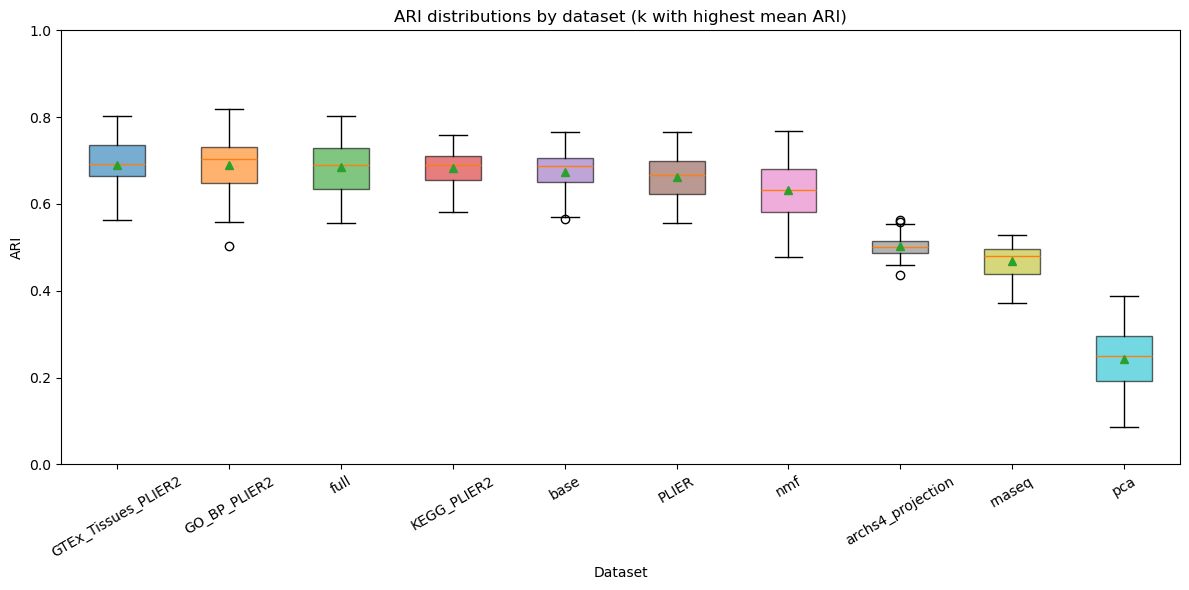

In [4]:
import re
import numpy as np
import matplotlib.pyplot as plt

candidate_names = [
    "best_k_gtex_GTEx_Tissues_PLIER2_kmeans_results_df",
    "best_k_gtex_KEGG_PLIER2_kmeans_results_df",
    "best_k_gtex_GO_BP_PLIER2_kmeans_results_df",
    "best_k_gtex_base_kmeans_results_df",
    "best_k_gtex_full_kmeans_results_df",
    "best_k_gtex_PLIER_kmeans_results_df",
    "best_k_gtex_rnaseq_kmeans_results_df",
    "best_k_gtex_archs4_projection",
    "best_k_gtex_pca_kmeans_results_df",
    "best_k_gtex_nmf_kmeans_results_df",  
]

datasets = {name: globals().get(name) for name in candidate_names}
datasets = {k: v for k, v in datasets.items() if v is not None and "ari" in v.columns and len(v)}

def clean_name(name: str) -> str:
    name = re.sub(r"^best_k_gtex_", "", name)
    name = re.sub(r"_kmeans_results_df$", "", name)
    return name

means = {name: df["ari"].mean() for name, df in datasets.items()}
ordered_names = sorted(means, key=lambda n: means[n], reverse=True)

data = [datasets[name]["ari"].to_numpy(dtype=float) for name in ordered_names]
labels = [clean_name(name) for name in ordered_names]

colors = plt.cm.tab10.colors
box_colors = [colors[i % len(colors)] for i in range(len(labels))]

plt.figure(figsize=(12, 6))
box = plt.boxplot(
    data,
    tick_labels=labels,
    showmeans=True,
    patch_artist=True
)

for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.ylabel("ARI")
plt.xlabel("Dataset")
plt.title("ARI distributions by dataset (k with highest mean ARI)")
plt.xticks(rotation=30, ha="center")  # centered labels
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

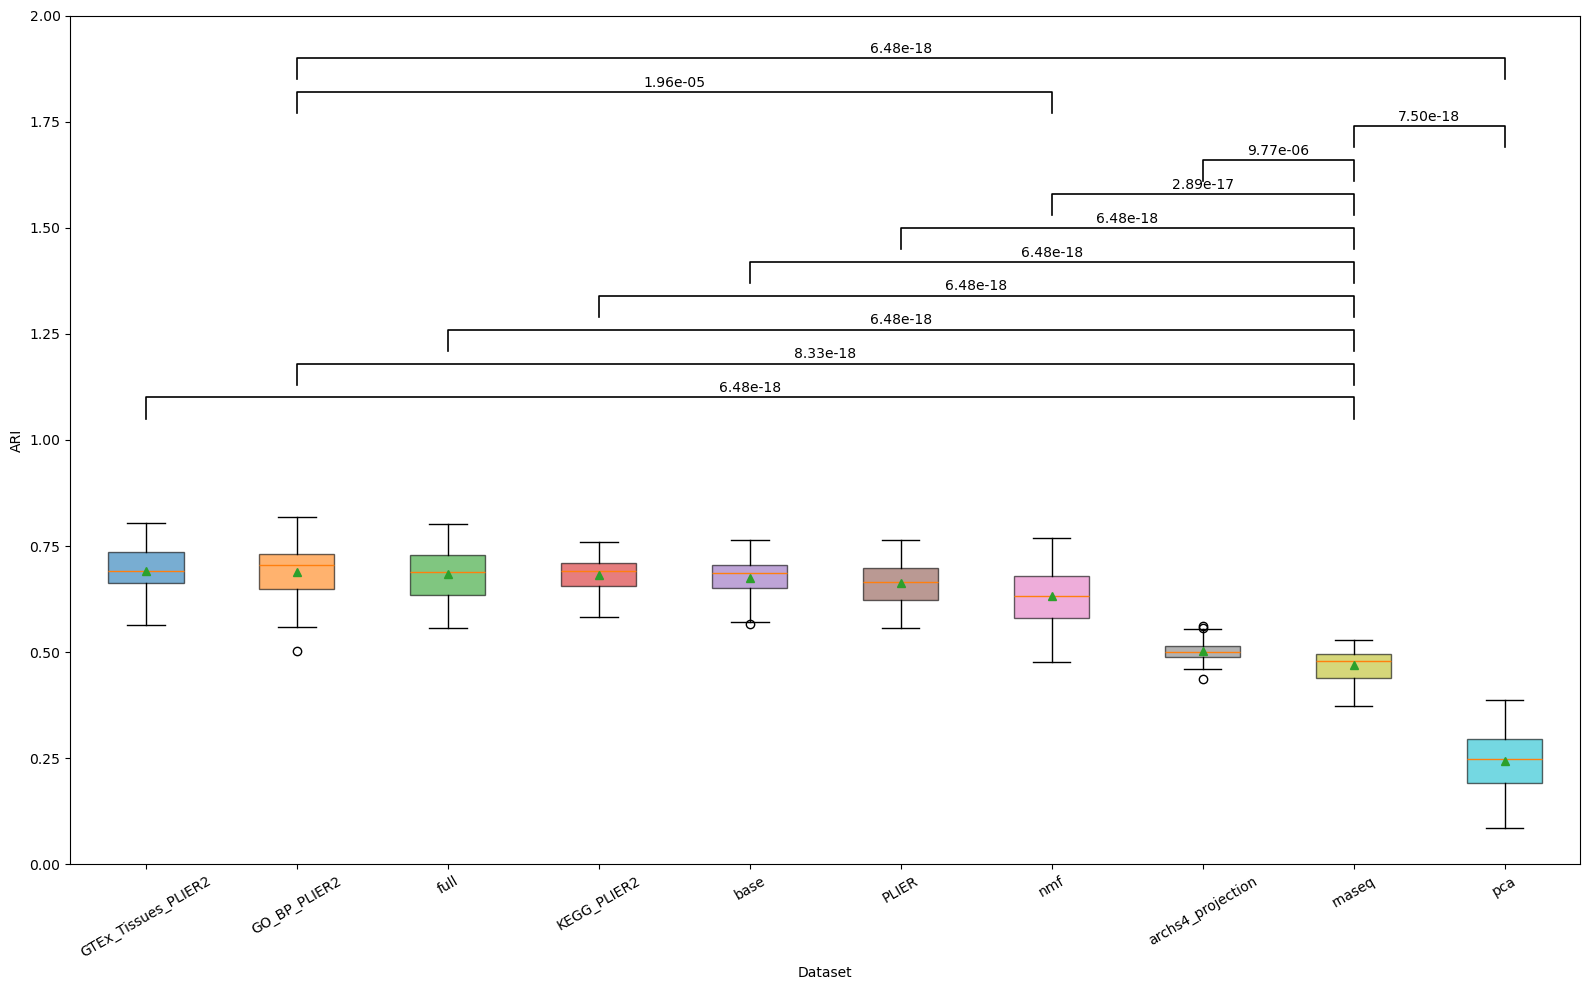

In [24]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

candidate_names = [
    "best_k_gtex_GTEx_Tissues_PLIER2_kmeans_results_df",
    "best_k_gtex_KEGG_PLIER2_kmeans_results_df",
    "best_k_gtex_GO_BP_PLIER2_kmeans_results_df",
    "best_k_gtex_base_kmeans_results_df",
    "best_k_gtex_full_kmeans_results_df",
    "best_k_gtex_PLIER_kmeans_results_df",
    "best_k_gtex_rnaseq_kmeans_results_df",
    "best_k_gtex_archs4_projection",
    "best_k_gtex_pca_kmeans_results_df",
    "best_k_gtex_nmf_kmeans_results_df",
]

datasets = {name: globals().get(name) for name in candidate_names}
datasets = {k: v for k, v in datasets.items() if v is not None and "ari" in v.columns and len(v)}

def clean_name(name: str) -> str:
    name = re.sub(r"^best_k_gtex_", "", name)
    name = re.sub(r"_kmeans_results_df$", "", name)
    return name

means = {name: df["ari"].mean() for name, df in datasets.items()}
ordered_names = sorted(means, key=lambda n: means[n], reverse=True)

data = [datasets[name]["ari"].to_numpy(float) for name in ordered_names]
labels = [clean_name(name) for name in ordered_names]

plt.figure(figsize=(16, 10))
box = plt.boxplot(data, tick_labels=labels, showmeans=True, patch_artist=True)
for patch, color in zip(box["boxes"], plt.cm.tab10.colors * 3):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.ylabel("ARI")
plt.xlabel("Dataset")
plt.xticks(rotation=30, ha="center")
plt.ylim(0, 2)

pairs = []
pairs += [("rnaseq", lab) for lab in labels if lab != "rnaseq"]
pairs += [("GO_BP_PLIER2", "nmf"), ("GO_BP_PLIER2", "pca")]

def mw_p_directional(a, b):
    a = np.asarray(a); b = np.asarray(b)
    if np.median(a) > np.median(b):
        return mannwhitneyu(a, b, alternative="greater").pvalue
    else:
        return mannwhitneyu(a, b, alternative="less").pvalue

raw_p = []
for a, b in pairs:
    i = labels.index(a); j = labels.index(b)
    raw_p.append(mw_p_directional(data[i], data[j]))

def fdr_bh(pvals):
    p = np.asarray(pvals, dtype=float)
    m = len(p)
    order = np.argsort(p)
    ranked = p[order]
    q = ranked * m / (np.arange(m) + 1)
    q = np.minimum.accumulate(q[::-1])[::-1]
    q_adj = np.empty_like(q)
    q_adj[order] = q
    return np.clip(q_adj, 0, 1)

pvals_adj = fdr_bh(raw_p)

ax = plt.gca()
xpos = {lab: x for lab, x in zip(labels, range(1, len(labels) + 1))}

def draw_bar(x1, x2, y, h, txt):
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c="black")
    ax.text((x1 + x2) / 2, y + h + 0.005, txt, ha="center", va="bottom")

base_y = 1.05
h = 0.05
gap = 0.03
y = base_y
for (a, b), adj_p in zip(pairs, pvals_adj):
    x1, x2 = sorted([xpos[a], xpos[b]])
    draw_bar(x1, x2, y, h, f"{adj_p:.2e}")
    y += h + gap

plt.tight_layout()
plt.show()


/tmp/ipykernel_113638/1519735377.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(classes))


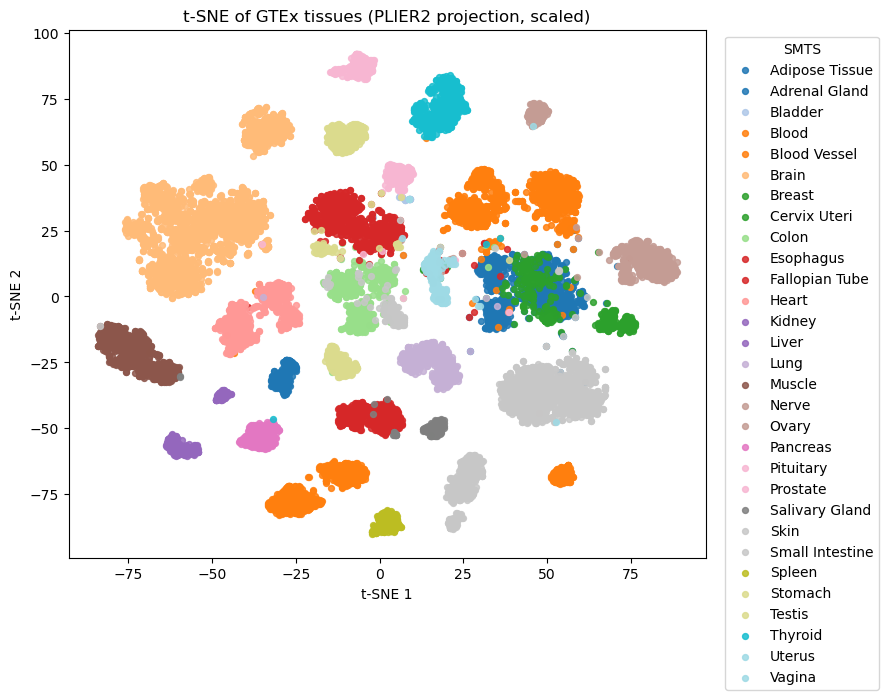

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

B = gtex_GTEx_Tissues_PLIER2.copy()
B.columns = B.columns.astype(str).str.strip()

common_ids = B.columns.intersection(meta.index)
if len(common_ids) == 0:
    raise ValueError("No overlapping sample IDs between B and metadata.")

B_common = B.loc[:, common_ids]
X_gtex_tissue = B_common.T.astype(np.float32)

scaler = StandardScaler()
X_gtex_tissue_scaled = scaler.fit_transform(X_gtex_tissue)

y_true = meta.loc[common_ids, "SMTS"].astype(str).to_numpy()

n = X_gtex_tissue_scaled.shape[0]
perplexity = max(5, min(30, (n - 1) // 3)) if n > 10 else 5

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    learning_rate="auto",
    init="pca",
    max_iter=1000,
    random_state=0
)
emb = tsne.fit_transform(X_gtex_tissue_scaled)

classes = np.unique(y_true)
class_to_idx = {c: i for i, c in enumerate(classes)}
cmap = plt.cm.get_cmap("tab20", len(classes))

plt.figure(figsize=(9, 7))
for c in classes:
    m = (y_true == c)
    plt.scatter(emb[m, 0], emb[m, 1], s=18, alpha=0.85, label=c, c=[cmap(class_to_idx[c])])
plt.legend(title="SMTS", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE of GTEx tissues (PLIER2 projection, scaled)")
plt.tight_layout()
plt.show()
